# Setup

In [11]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

In [12]:
# loading college scorecard data from 2013-2014 because it has the most data to work with compared to more recent years
df = pd.read_csv('MERGED2013_14_PP.csv', dtype = str)

In [13]:
# setting up columns we want to look at
institution_name = 'INSTNM' #string
undergraduate_enrollment = 'UGDS' #int
state = 'STABBR' #string
avg_cost_of_attendance_academic_institutions = 'COSTT4_A' #int
#count_of_students_in_earnings_cohort = 'COUNT_ED' #int
# wne = 'working not enrolled'
count_of_students_wne_10y_after_entry = 'COUNT_WNE_P10' #int
mean_earnings_of_students_wne_10y_after_entry = 'MN_EARN_WNE_P10' #int
median_earnings_of_students_wne_10y_after_entry = 'MD_EARN_WNE_P10' #int
stddev_earnings_of_students_wne_10y_after_entry = 'SD_EARN_WNE_P10' #int

count_of_students_wne_6y_after_entry = 'COUNT_WNE_P6' #int
mean_earnings_of_students_wne_6y_after_entry = 'MN_EARN_WNE_P6' #int
median_earnings_of_students_wne_6y_after_entry = 'MD_EARN_WNE_P6' #int
stddev_earnings_of_students_wne_6y_after_entry = 'SD_EARN_WNE_P6' #int

median_debt_for_graduated_students = 'GRAD_DEBT_MDN' #float
percent_degrees_in_engineering = 'PCIP15'

relevantColumns = [institution_name,
                   state,
                   undergraduate_enrollment, 
                   avg_cost_of_attendance_academic_institutions, 
                  count_of_students_wne_10y_after_entry,
                  mean_earnings_of_students_wne_10y_after_entry,
                  median_earnings_of_students_wne_10y_after_entry,
                  stddev_earnings_of_students_wne_10y_after_entry,
                  count_of_students_wne_6y_after_entry,
                  mean_earnings_of_students_wne_6y_after_entry,
                  median_earnings_of_students_wne_6y_after_entry,
                  stddev_earnings_of_students_wne_6y_after_entry,
                  median_debt_for_graduated_students,
                  percent_degrees_in_engineering]


# Data Cleaning

In [14]:
#df[df[field].notnull()][field]
# remove all other column data
df = df.loc[:, df.columns.intersection(relevantColumns)]

# remove specialized program institutions from the dataframe (they will have NaN for academic institution cost of attendance)
#df = df.dropna(subset=[avg_cost_of_attendance_academic_institutions])

# remove all rows that have null
df = df.dropna(how='any')

# update type for int columns
for col in relevantColumns[2:-2]:
    if(df[col].dtype == object):
        # remove rows with 'PrivacySuppressed'
        df = df[df[col]!='PrivacySuppressed']
        df[col] = df[col].astype('int')

# update type for float columns
for col in relevantColumns[-2:]:
    if(df[col].dtype == object):
        # remove rows with 'PrivacySuppressed'
        df = df[df[col]!='PrivacySuppressed']
        df[col] = df[col].astype('float')

# remove schools with less than 2000 undergraduate students enrolled
df[undergraduate_enrollment] = df[undergraduate_enrollment].astype('int')
df = df[df[undergraduate_enrollment] >= 2000]


In [15]:
i = 11
#print(relevantColumns[i])
#print(df[relevantColumns[i]])
#print(df.columns)

In [16]:
#can separate by state for bar graphs
df.head()

,INSTNM,STABBR,PCIP15,UGDS,COSTT4_A,GRAD_DEBT_MDN,COUNT_WNE_P10,MN_EARN_WNE_P10,MD_EARN_WNE_P10,SD_EARN_WNE_P10,COUNT_WNE_P6,MN_EARN_WNE_P6,MD_EARN_WNE_P6,SD_EARN_WNE_P6
0,Alabama A & M University,AL,0.0348,4051,18888,29500.0,1741,34300,29900,25300,1187,27200,23100,24200
1,University of Alabama at Birmingham,AL,0.0000,11200,19990,20345.5,3474,46400,40200,36300,2665,38300,34000,29800
3,University of Alabama in Huntsville,AL,0.0000,5525,20306,22750.0,1361,50500,45600,32700,1258,39200,35500,25800
4,Alabama State University,AL,0.0000,5354,17400,31200.0,1977,29500,26700,20500,1594,23100,21000,15100
5,The University of Alabama,AL,0.0000,28692,26717,22910.0,3648,49900,42700,42600,4322,39000,34800,41800


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


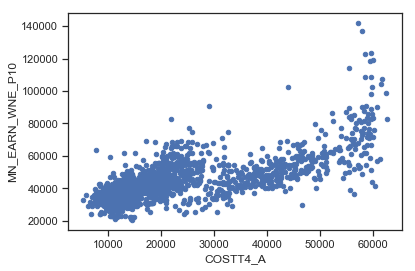

In [17]:
df.plot.scatter(x=avg_cost_of_attendance_academic_institutions,y=mean_earnings_of_students_wne_10y_after_entry)

f1 = plt.gcf()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


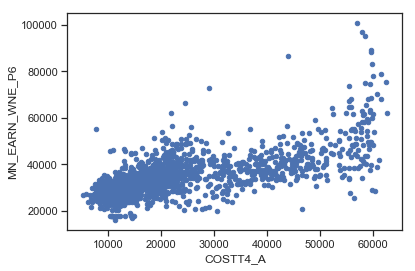

In [18]:
df.plot.scatter(x=avg_cost_of_attendance_academic_institutions,y=mean_earnings_of_students_wne_6y_after_entry)

f2 = plt.gcf()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


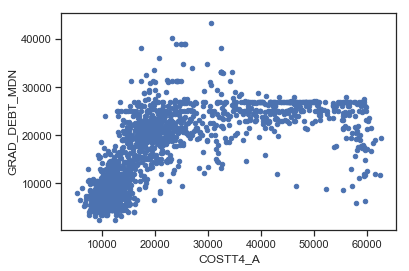

In [19]:
df.plot.scatter(x=avg_cost_of_attendance_academic_institutions,y=median_debt_for_graduated_students)

f3 = plt.gcf()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


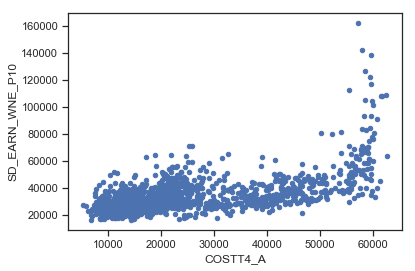

In [20]:
df.plot.scatter(x=avg_cost_of_attendance_academic_institutions,y=stddev_earnings_of_students_wne_10y_after_entry)

f4 = plt.gcf()
f3 = plt.gcf()

In [21]:
# count how many institutions per state
state_labels = set(df[state])
state_institution_count = {};
state_institutions = {};
for label in state_labels:
    count = len(df[df[state]==label])
    state_institution_count[label] = count
    state_institutions[label] = df.loc[df[state] == label]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


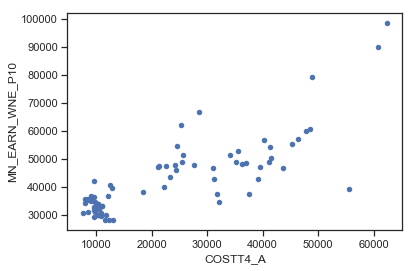

In [22]:
state_institutions['IL'].plot.scatter(x=avg_cost_of_attendance_academic_institutions,y=mean_earnings_of_students_wne_10y_after_entry)

f5 = plt.gcf()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


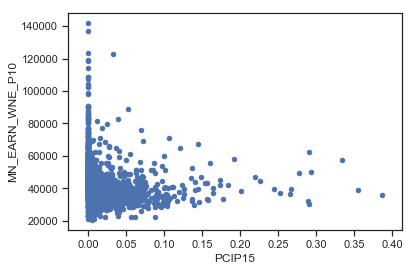

In [23]:
df.plot.scatter(x=percent_degrees_in_engineering,y=mean_earnings_of_students_wne_10y_after_entry)

f6 = plt.gcf()

In [24]:
md_earning6 = df['MD_EARN_WNE_P6'].mean()
avg_earning6 = df['MN_EARN_WNE_P6'].mean()
avg_cost = df['COSTT4_A'].mean()

cost_leaving = 4*avg_cost
md_dbt_leaving = df['GRAD_DEBT_MDN'].mean()
#Plotting with interest
y = [0]*8
y[0]= md_dbt_leaving
for i in range(1,8):
    y[i]= y[i-1]*(1.055)-.10*(md_earning6)
    

#without interest the years to recoup investement
yrs_in= cost_leaving/md_earning6
#This is about 3


Text(0, 0.5, 'Debt in Dollars')

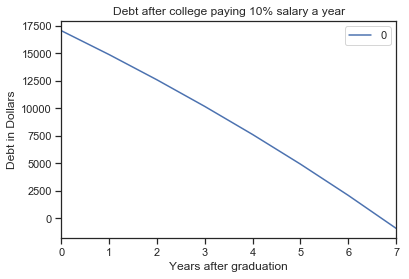

In [25]:
yf = pd.DataFrame(y)
yf.plot(title= 'Debt after college paying 10% salary a year')
plt.xlabel('Years after graduation')
plt.ylabel('Debt in Dollars')

In [26]:
#df.plot(x='STABBR', y='MN_EARN_WNE_P10')

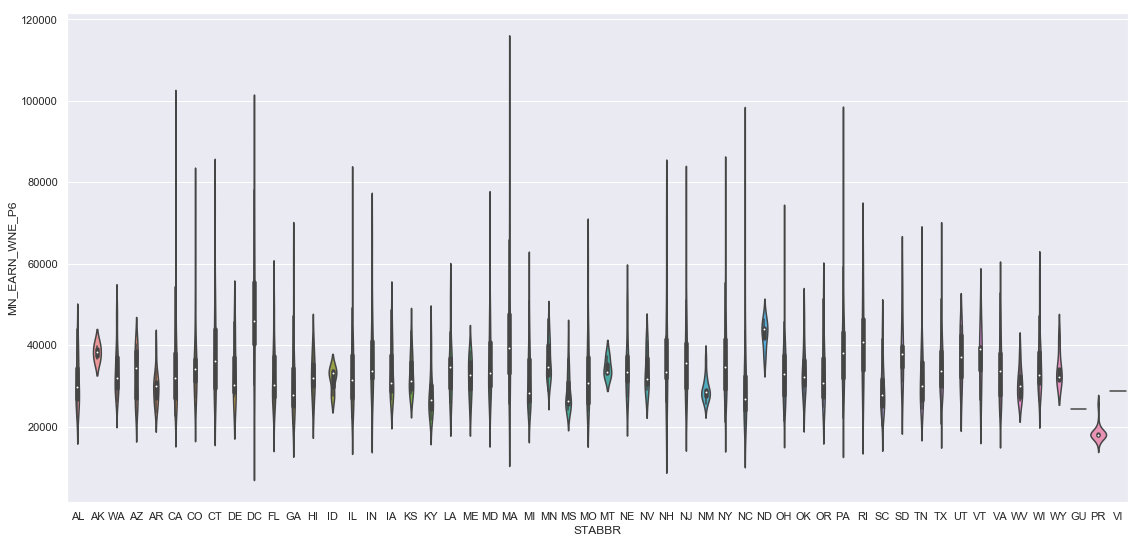

In [27]:
sns.set(rc={'figure.figsize':(19,9)})
sns.violinplot(x= df["STABBR"],y=df["MN_EARN_WNE_P6"])